In [415]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [416]:
# df = pd.read_csv('Data/collective1972-2023.csv')

# df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])
# df.set_index('LOCAL_DATE', inplace=True)

# columns_to_plot = df.iloc[:, :]

# # Loop through each selected column and plot it
# for column in columns_to_plot.columns:
#     if pd.api.types.is_numeric_dtype(columns_to_plot[column]):
#         plt.figure(figsize=(10, 5))  # Set the figure size
#         plt.plot(df.index, columns_to_plot[column], marker='.')  # Plot each column as a line graph
#         plt.title(f'Line Graph for {column}')  # Title with the column name
#         plt.xlabel('Date')  # Label for the x-axis
#         plt.ylabel(column)  # Label for the y-axis
#         plt.grid(True)  # Add a grid for better readability
#         plt.show()  # Display the plot
#     else:
#         print(f"Skipping column {column} as it is not numeric.")

In [417]:
df = pd.read_csv('Data/collective1972-2023.csv')

# Extract year, month, and day into separate columns
df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])
df = pd.get_dummies(df, columns=['SYM'], dummy_na=True)
# df['Month'] = df['LOCAL_DATE'].dt.month
# df = pd.get_dummies(df, columns=['Month'])


# Drop any non-numeric columns that aren't needed for training
df.drop(['LOCAL_DATE', 'CITY', 'STATION', 'LATITUDE', 'LONGITUDE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST',  
          'COOLING_DEGREE_DAYS', 'TOTAL_RAIN', 'TOTAL_SNOW', 'SNOW_ON_GROUND', 'Flow-1', 'Flow-2', 'Flow-3', 'HEATING_DEGREE_DAYS'], axis=1, inplace=True)

# # Create new columns with flow values after 1 day, 2 days, 3 days
df['Flow+1'] = df['Flow0'].shift(-1)  # Shift up by 1
df['Flow+2'] = df['Flow0'].shift(-2)  # Shift up by 2
df['Flow+3'] = df['Flow0'].shift(-3)  # Shift up by 3

# Impute missing values
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
# Linear interpolation (default)
df_imputed = df.interpolate(method='linear')
df_imputed = df.dropna()

print(df_imputed.describe())
# Define X and Y
Y = df_imputed[['Flow0', 'Flow+1', 'Flow+2', 'Flow+3']]  # Target variable
# Y = df_imputed[['Flow0']]  # Target variable
X = df_imputed.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
# X = df_imputed.drop(['Flow0'], axis=1)  # Features

       MAX_REL_HUMIDITY  MIN_REL_HUMIDITY  TOTAL_PRECIPITATION  \
count       9644.000000       9644.000000          9644.000000   
mean          90.005185         47.189029             1.372091   
std            9.310513         19.893923             3.479862   
min           39.000000          6.000000             0.000000   
25%           86.000000         31.000000             0.000000   
50%           93.000000         44.000000             0.000000   
75%           97.000000         61.000000             1.000000   
max          100.000000         98.000000            89.000000   

       MAX_TEMPERATURE  MEAN_TEMPERATURE  MIN_TEMPERATURE        Flow0  \
count      9644.000000       9644.000000      9644.000000  9644.000000   
mean          9.732150          3.638895        -2.463905   840.659270   
std          11.802043         10.560496        10.020704   797.543585   
min         -29.800000        -36.600000       -45.000000    75.000000   
25%           1.700000         -2.8

In [418]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
# Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()
Y_scaled = scaler_Y.fit_transform(Y)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.20, random_state=3)


In [419]:

# Train the SVR model
# 'C': 100, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'
svr_linear = SVR(kernel='rbf', C=10, epsilon=0.00001)
multi_svr_linear = MultiOutputRegressor(svr_linear)
multi_svr_linear.fit(X_train, Y_train)


MultiOutputRegressor(estimator=SVR(C=10, epsilon=1e-05))

In [420]:

# Make predictions
Y_pred_scaled = multi_svr_linear.predict(X_test)

# Assuming Y_test is already scaled (Y_test_scaled)
Y_test_scaled = Y_test  # If Y_test is already scaled, otherwise scale it before this step.


# Inverse transform predictions
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_pred = np.maximum(Y_pred, 0)  # Ensure no negative predictions

# Inverse transform Y_test
Y_test = scaler_Y.inverse_transform(Y_test_scaled)
Y_test = np.maximum(Y_test, 0)  # Ensure no negative values


In [421]:
# from sklearn.inspection import permutation_importance

# svr_linear = SVR(kernel='linear')
# multi_svr_linear = MultiOutputRegressor(svr_linear)
# multi_svr_linear.fit(X_train, Y_train)


# # Calculate permutation importance
# results = permutation_importance(multi_svr_linear, X_test, Y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=0)



In [422]:


# # Feature names
# features = ['HEATING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'TOTAL_RAIN', 'TOTAL_SNOW', 'SNOW_ON_GROUND', 'SNOW_ON_GROUND', 
#              'MAX_TEMPERATURE', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE', 'MAX_TEMPERATURE', 'SNOW_ON_GROUND', 'TOTAL_PRECIPITATION", 'Flow-1', 'Flow-2', 'Flow-3']

# # Create DataFrame for results
# importance_df = pd.DataFrame({
#     'Feature': features,
#     'Importance': np.mean(results.importances, axis=1)
# })

# # # Make predictions
# # Y_pred_scaled = multi_svr_linear.predict(X_test)
# # Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
# # Y_pred = np.maximum(Y_pred, 0)
# # Y_test = scaler_Y.inverse_transform(Y_test)

# # Set the style
# sns.set(style="whitegrid")

# # Plot
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Feature', y='Importance', data=importance_df, palette='viridis')
# plt.title('Feature Importance for SVR Model (Permutation Importance)')
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.xticks(rotation=45, ha='right')
# plt.show()


In [423]:

# # Define the parameter grid
# param_grid = {
#     'kernel': ['rbf'],
#     'C': [10.0, 100.0, 1000.0, 10000.0,],
#     'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
#     'epsilon': [0.000001]
#     # 'degree': [2, 3, 4]  # Only for polynomial kernel
# }

# # Perform grid search
# grid_search = GridSearchCV(SVR(), param_grid, refit=True, verbose=3, cv=2)
# grid_search.fit(X_train, Y_train)


# # Make predictions
# Y_pred_scaled = grid_search.predict(X_test)

# # Assuming Y_test is already scaled (Y_test_scaled)
# Y_test_scaled = Y_test  # If Y_test is already scaled, otherwise scale it before this step.


# # Inverse transform predictions
# Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
# Y_pred = np.maximum(Y_pred, 0)  # Ensure no negative predictions

# # Inverse transform Y_test
# Y_test = scaler_Y.inverse_transform(Y_test_scaled)
# Y_test = np.maximum(Y_test, 0)  # Ensure no negative values


# # Best parameters and score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

# # Predict with best estimator
# best_svr = grid_search.best_estimator_
# Y_pred = best_svr.predict(X_test)


In [424]:
for i in range(Y_pred.shape[1]):
    # Flow 0 Day -----------------------------------------------
    errors = abs(Y_pred[:, i] - Y_test[:, i])
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'm3/s.')


    mse = mean_squared_error(Y_test[:, i], Y_pred[:, i])
    print(f"Mean Squared Error (Flow +1): {round(np.mean(mse), 2)}")

    r_squared = r2_score(Y_test[:, i], Y_pred[:, i])
    print(f"R-squared (Flow +1): {round(np.mean(r_squared), 2)}")

    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (Flow +{i}): {round(np.mean(rmse), 2)}")
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / Y_test[:, i])
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%\n')

Mean Absolute Error: 353.98 m3/s.
Mean Squared Error (Flow +1): 330598.42
R-squared (Flow +1): 0.47
Root Mean Squared Error (Flow +0): 574.98
Accuracy: 55.6 %

Mean Absolute Error: 352.18 m3/s.
Mean Squared Error (Flow +1): 331173.6
R-squared (Flow +1): 0.48
Root Mean Squared Error (Flow +1): 575.48
Accuracy: 55.89 %

Mean Absolute Error: 352.07 m3/s.
Mean Squared Error (Flow +1): 331110.92
R-squared (Flow +1): 0.48
Root Mean Squared Error (Flow +2): 575.42
Accuracy: 55.84 %

Mean Absolute Error: 349.82 m3/s.
Mean Squared Error (Flow +1): 329393.51
R-squared (Flow +1): 0.48
Root Mean Squared Error (Flow +3): 573.93
Accuracy: 56.16 %



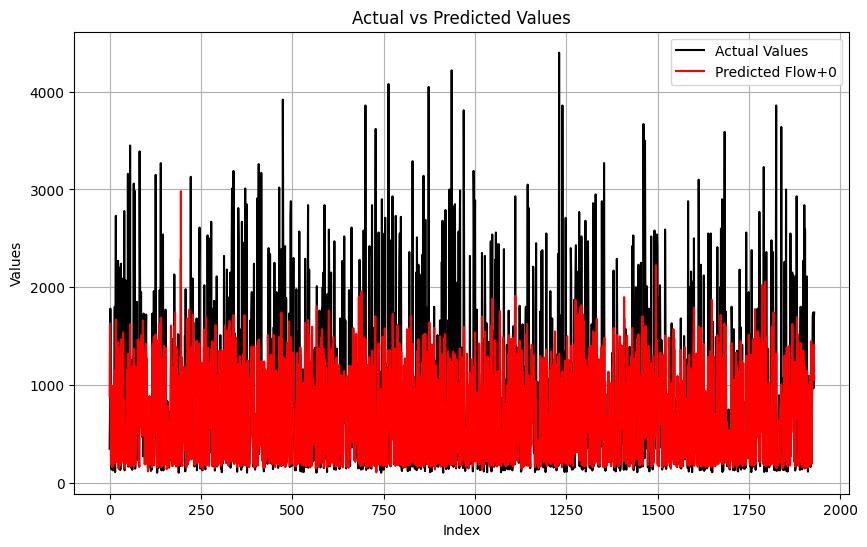

In [425]:
plt.figure(figsize=(10, 6))
# plt.plot(range(len(Y_test)), Y_test, color='black', label='Actual Values')
plt.plot(range(len(Y_test)), Y_test[:, 0], color='black', label='Actual Values')
# plt.plot(range(len(Y_test)), Y_test[:, 1], color='black', label='Actual Values')
# plt.plot(range(len(Y_test)), Y_test[:, 2], color='blue', label='Actual Values')
# plt.plot(range(len(Y_test)), Y_test[:, 3], color='blue', label='Actual Values')
# plt.plot(range(len(Y_pred)), Y_pred, color='red', label='Predicted Flow+0')
plt.plot(range(len(Y_pred)), Y_pred[:, 0], color='red', label='Predicted Flow+0')
# plt.plot(range(len(Y_pred)), Y_pred[:, 1], color='blue', label='Predicted Flow+1')
# plt.plot(range(len(Y_pred)), Y_pred[:, 2], color='red', label='Predicted Flow+2')
# plt.plot(range(len(Y_pred)), Y_pred[:, 3], color='red', label='Predicted Flow+3')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

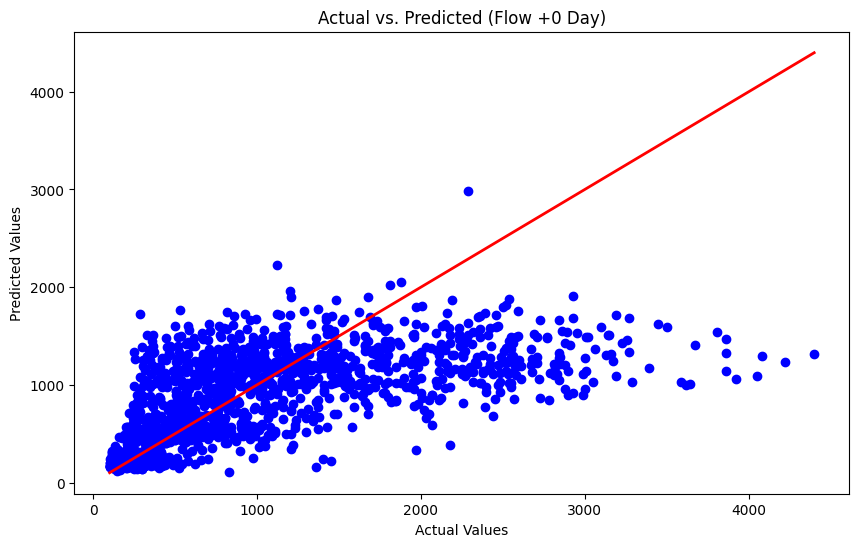

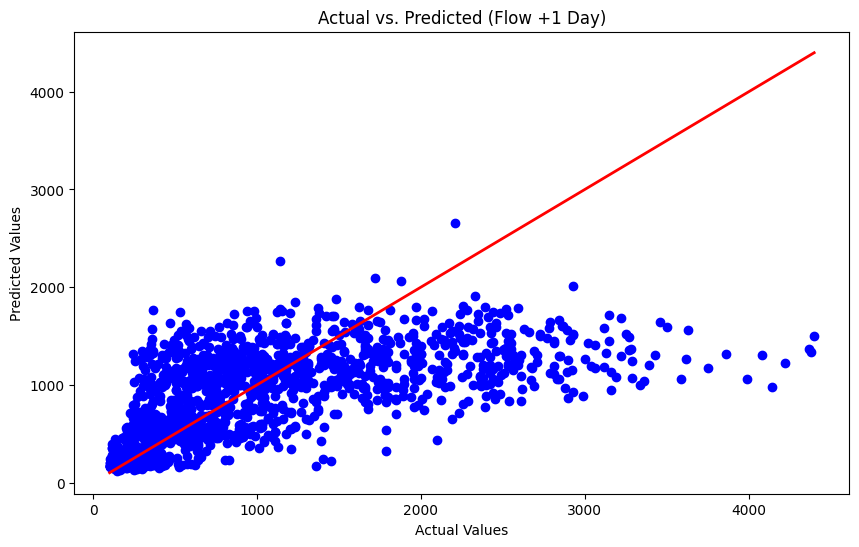

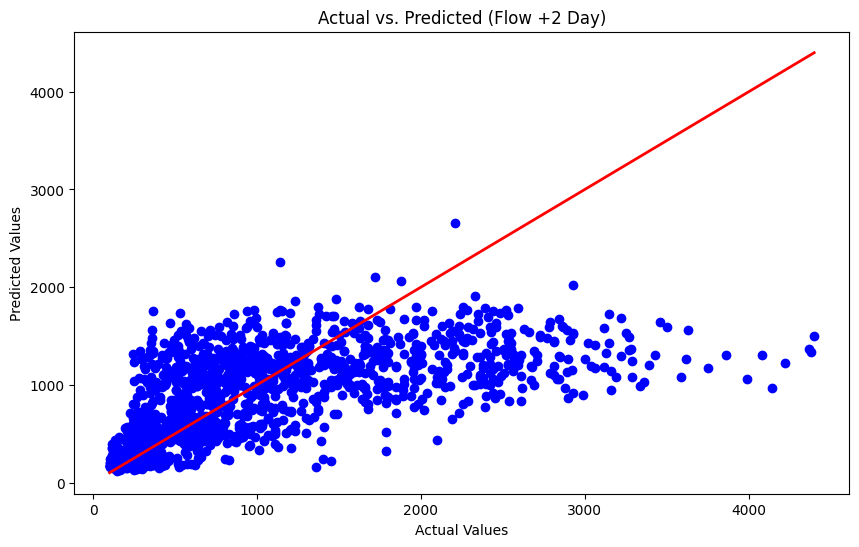

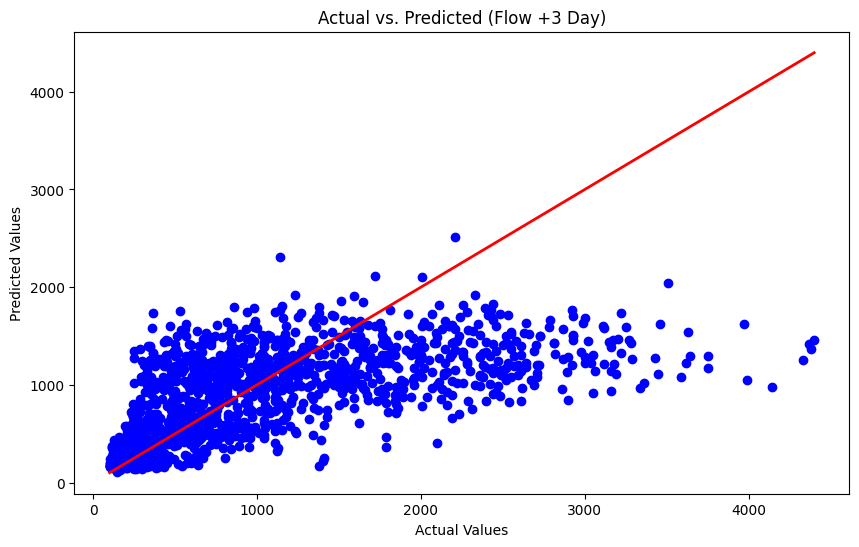

In [426]:
# Scatter plots for each output (Flow+1, Flow+2, Flow+3)
for i in range(Y_pred.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_test[:, i], Y_pred[:, i], color='blue')
    plt.plot([min(Y_test[:, i]), max(Y_test[:, i])], [min(Y_test[:, i]), max(Y_test[:, i])], color='red', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted (Flow +{i} Day)')
    plt.show()


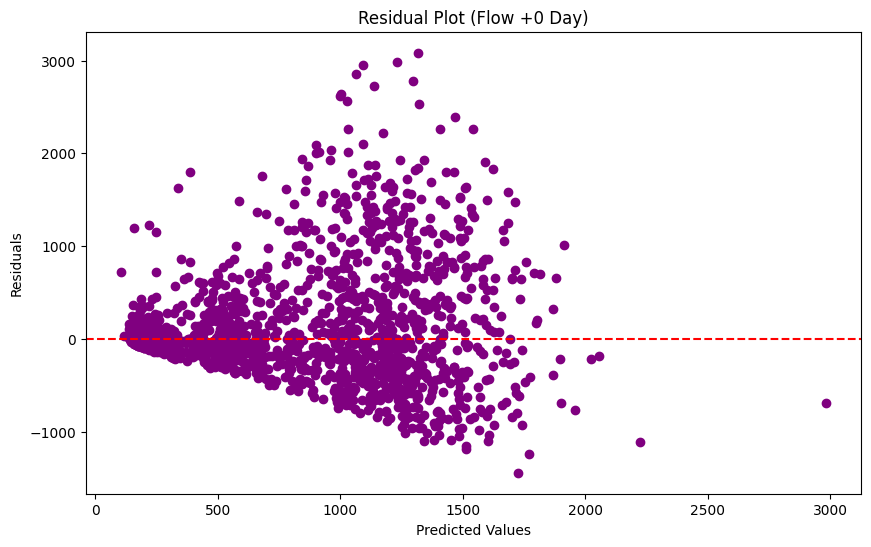

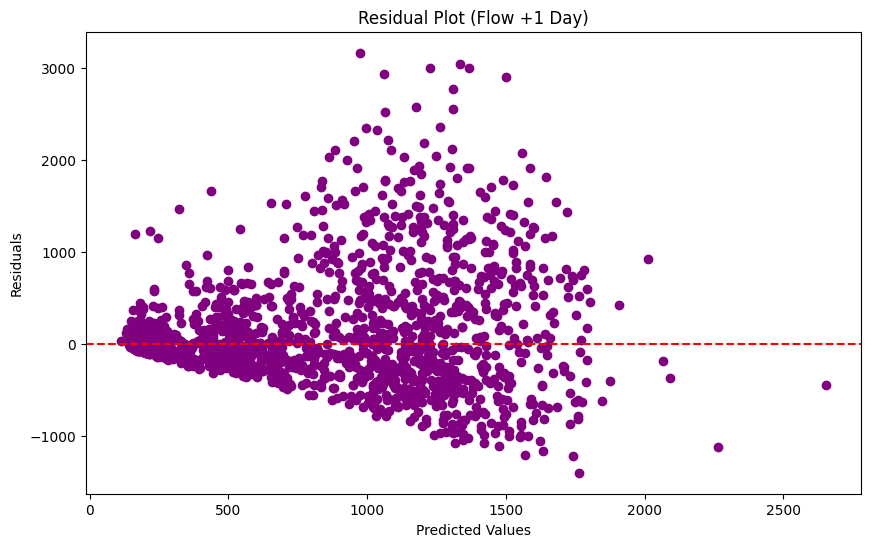

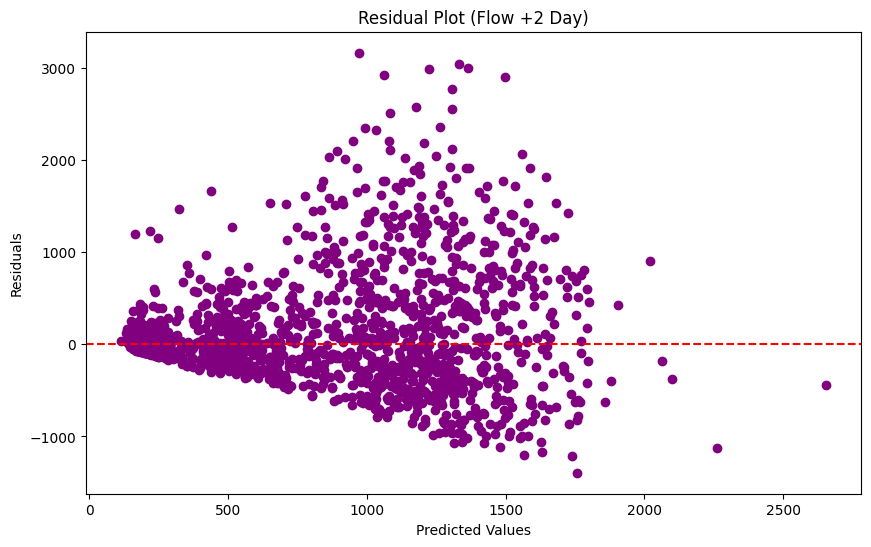

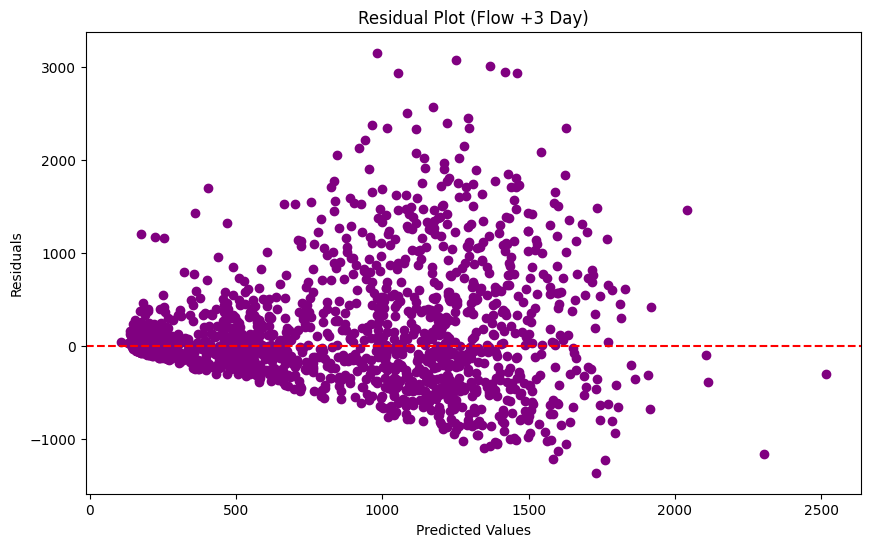

In [427]:
# Residual plots for each output (Flow+1, Flow+2, Flow+3)
for i in range(Y_pred.shape[1]):
    residuals = Y_test[:, i] - Y_pred[:, i]

    plt.figure(figsize=(10, 6))
    plt.scatter(Y_pred[:, i], residuals, color='purple')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot (Flow +{i} Day)')
    plt.show()


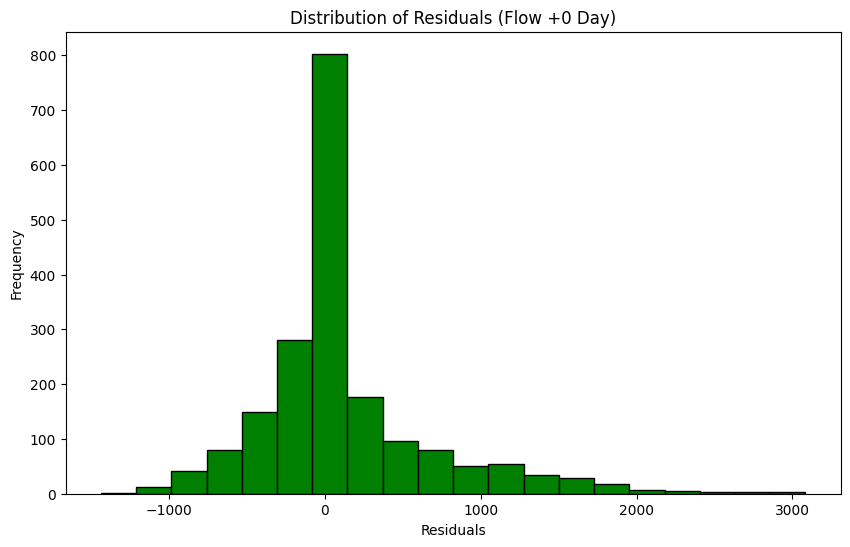

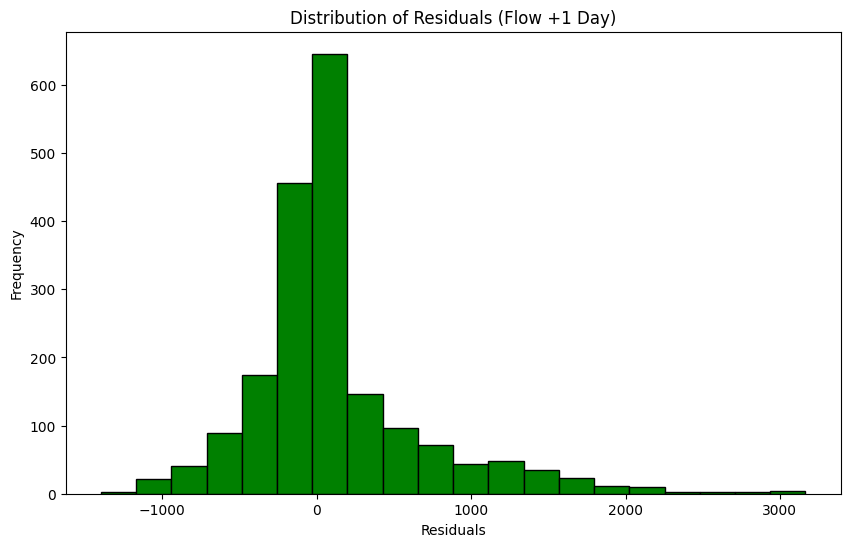

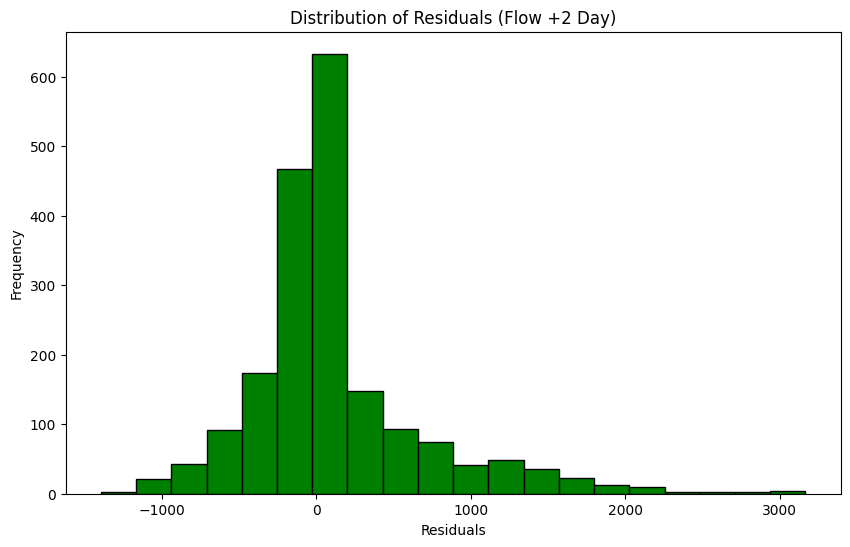

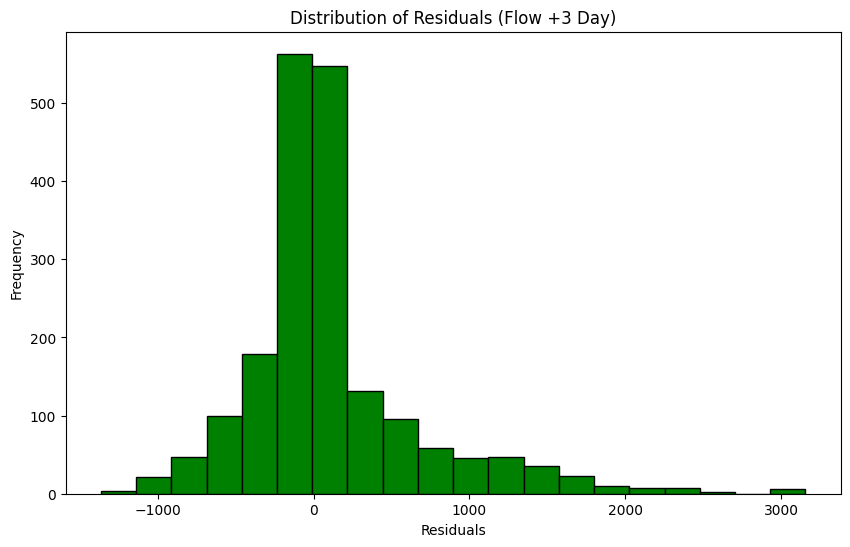

In [428]:
# Histogram of residuals for each output (Flow+1, Flow+2, Flow+3)
for i in range(Y_pred.shape[1]):
    residuals = Y_test[:, i] - Y_pred[:, i]

    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=20, color='green', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Residuals (Flow +{i} Day)')
    plt.show()


In [429]:
# new_data = pd.read_csv('Data/liard1944-2013.csv')  # Replace with the actual path to your new dataset

# new_data['LOCAL_DATE'] = pd.to_datetime(new_data['LOCAL_DATE'])
# new_data.set_index('LOCAL_DATE', inplace=True)

# columns_to_plot = new_data.iloc[:, :]

# # Loop through each selected column and plot it
# for column in columns_to_plot.columns:
#     if pd.api.types.is_numeric_dtype(columns_to_plot[column]):
#         plt.figure(figsize=(10, 5))  # Set the figure size
#         plt.plot(new_data.index, columns_to_plot[column], marker='.')  # Plot each column as a line graph
#         plt.title(f'Line Graph for {column}')  # Title with the column name
#         plt.xlabel('Date')  # Label for the x-axis
#         plt.ylabel(column)  # Label for the y-axis
#         plt.grid(True)  # Add a grid for better readability
#         plt.show()  # Display the plot
#     else:
#         print(f"Skipping column {column} as it is not numeric.")

In [430]:
new_data = pd.read_csv('Data/liard1944-2013.csv')  # Replace with the actual path to your new dataset

# Extract year, month, and day into separate columns
new_data['LOCAL_DATE'] = pd.to_datetime(new_data['LOCAL_DATE'])
new_data = pd.get_dummies(new_data, columns=['SYM'], dummy_na=True)
# new_data['Month'] = new_data['LOCAL_DATE'].dt.month
# new_data = pd.get_dummies(new_data, columns=['Month'])


# Drop any non-numeric columns that aren't needed for training
new_data.drop(['LOCAL_DATE', 'CITY', 'STATION', 'LATITUDE', 'LONGITUDE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST', 
                 'COOLING_DEGREE_DAYS', 'TOTAL_RAIN', 'TOTAL_SNOW', 'SNOW_ON_GROUND', 'Flow-1', 'Flow-2', 'Flow-3', 'HEATING_DEGREE_DAYS'], axis=1, inplace=True)

# Create new columns with flow values after 1 day, 2 days, 3 days
new_data['Flow+1'] = new_data['Flow0'].shift(-1)  # Shift up by 1
new_data['Flow+2'] = new_data['Flow0'].shift(-2)  # Shift up by 2
new_data['Flow+3'] = new_data['Flow0'].shift(-3)  # Shift up by 3

# Impute missing values
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# new_data_imputed = pd.DataFrame(imputer.fit_transform(new_data), columns=new_data.columns)
# Linear interpolation (default)
new_data_imputed = new_data.interpolate(method='linear')
new_data_imputed = new_data.dropna()

# selected_data = new_data_imputed.iloc[420:430]

# new_data_imputed.drop(new_data_imputed.index[4000:6000], inplace=True)

print(new_data_imputed.describe())
print(new_data_imputed.head(4))
# Define X and Y
Y2 = new_data_imputed[['Flow0', 'Flow+1', 'Flow+2', 'Flow+3']]  # Target variable
# Y2 = new_data_imputed[['Flow0']]  # Target variable
X2 = new_data_imputed.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
# X2 = new_data_imputed.drop(['Flow0'], axis=1)  # Features

       MAX_REL_HUMIDITY  MIN_REL_HUMIDITY  TOTAL_PRECIPITATION  \
count      10080.000000      10080.000000         10080.000000   
mean          87.431052         52.824702             1.210734   
std            8.407756         18.796436             2.884125   
min           37.000000          6.000000             0.000000   
25%           83.000000         37.000000             0.000000   
50%           89.000000         52.000000             0.000000   
75%           93.000000         70.000000             1.000000   
max          100.000000         97.000000            41.800000   

       MAX_TEMPERATURE  MEAN_TEMPERATURE  MIN_TEMPERATURE         Flow0  \
count     10080.000000      10080.000000     10080.000000  10080.000000   
mean          4.937004         -0.864573        -6.672490   1249.494444   
std          14.241991         13.896386        13.940894   1309.416658   
min         -38.100000        -43.300000       -50.300000    125.000000   
25%          -6.100000        

In [431]:
scaler_X2 = StandardScaler()
scaler_Y2 = StandardScaler()

X_scaled2 = scaler_X2.fit_transform(X2)
# Y_scaled2 = scaler_Y2.fit_transform(Y.values.reshape(-1, 1)).flatten()
Y_scaled2 = scaler_Y2.fit_transform(Y2)

Y_pred_scaled2 = multi_svr_linear.predict(X_scaled2)
# Y_pred2 = scaler_Y.inverse_transform(Y_pred_scaled2.reshape(-1, 1)).flatten()
Y_pred2 = scaler_Y2.inverse_transform(Y_pred_scaled2)
Y_pred2 = np.maximum(Y_pred2, 0)

Y2 = scaler_Y2.inverse_transform(Y_scaled2)
Y2 = np.maximum(Y2, 0)

# Example: Viewing predictions
print(Y_pred2)



[[ 882.07856648  975.79119046  973.43525798  963.30582413]
 [ 582.39940165  599.55261301  597.02549955  638.39921433]
 [ 666.21630987  714.87725151  711.87577731  712.93546535]
 ...
 [1765.45422784 1745.35662494 1743.02559326 1709.98130574]
 [1908.4882192  1879.46852556 1881.33016189 1864.12975531]
 [1172.20226453 1308.50150034 1320.93337772 1215.94560001]]


In [432]:
for i in range(Y_pred2.shape[1]):
    # Flow 0 Day -----------------------------------------------
    errors = abs(Y_pred2[:, i] - Y2[:, i])
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'm3/s.')


    mse = mean_squared_error(Y2[:, i], Y_pred2[:, i])
    print(f"Mean Squared Error (Flow +1): {round(np.mean(mse), 2)}")

    r_squared = r2_score(Y2[:, i], Y_pred2[:, i])
    print(f"R-squared (Flow +1): {round(np.mean(r_squared), 2)}")

    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (Flow +{i}): {round(np.mean(rmse), 2)}")
        # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / Y2[:, i])
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%\n')

Mean Absolute Error: 580.36 m3/s.
Mean Squared Error (Flow +1): 1023368.51
R-squared (Flow +1): 0.4
Root Mean Squared Error (Flow +0): 1011.62
Accuracy: 50.6 %

Mean Absolute Error: 581.65 m3/s.
Mean Squared Error (Flow +1): 1017405.37
R-squared (Flow +1): 0.41
Root Mean Squared Error (Flow +1): 1008.67
Accuracy: 49.38 %

Mean Absolute Error: 578.09 m3/s.
Mean Squared Error (Flow +1): 1013569.96
R-squared (Flow +1): 0.41
Root Mean Squared Error (Flow +2): 1006.76
Accuracy: 49.9 %

Mean Absolute Error: 581.0 m3/s.
Mean Squared Error (Flow +1): 1020554.19
R-squared (Flow +1): 0.4
Root Mean Squared Error (Flow +3): 1010.22
Accuracy: 49.37 %



In [433]:
# Define the range of indices you want to plot
start_index = 1000
end_index = 3000


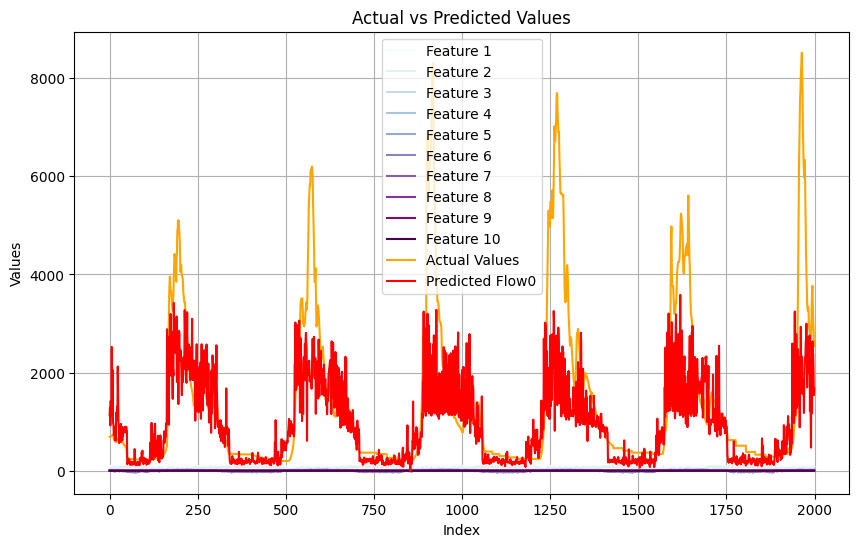

Index(['MAX_REL_HUMIDITY', 'MIN_REL_HUMIDITY', 'TOTAL_PRECIPITATION',
       'MAX_TEMPERATURE', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE', 'SYM_A',
       'SYM_B', 'SYM_E', 'SYM_nan'],
      dtype='object')


In [434]:

# Ensure indices are within bounds
start_index = max(start_index, 0)
end_indexY = min(end_index, len(Y2))
end_indexX = min(end_index, len(X2))

# Slice the arrays
Y2_subset = Y2[start_index:end_indexY]
Y_pred2_subset = Y_pred2[start_index:end_indexY]
X2_subset = X2[start_index:end_indexX]

plt.figure(figsize=(10, 6))
# plt.plot(range(len(Y2_subset)), Y2_subset, color='orange', label='Actual Values')

#Define a color map for features
colors = plt.cm.BuPu(np.linspace(0, 1, X2.shape[1]))

# Plot each feature with a different color
for i in range(X2.shape[1]):
    plt.plot(range(len(X2_subset)), X2_subset.iloc[:, i], color=colors[i], label=f'Feature {i+1}')
plt.plot(range(len(Y2_subset)), Y2_subset[:, 0], color='orange', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 1], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 2], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 3], color='blue', label='Actual Values')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 0], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 1], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 2], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 3], color='green', label='Feature')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset, color='red', label='Predicted Flow0')
plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 0], color='red', label='Predicted Flow0')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 1], color='red', label='Predicted Flow+1')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 2], color='red', label='Predicted Flow+2')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 3], color='red', label='Predicted Flow+3')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

print(X2.columns)

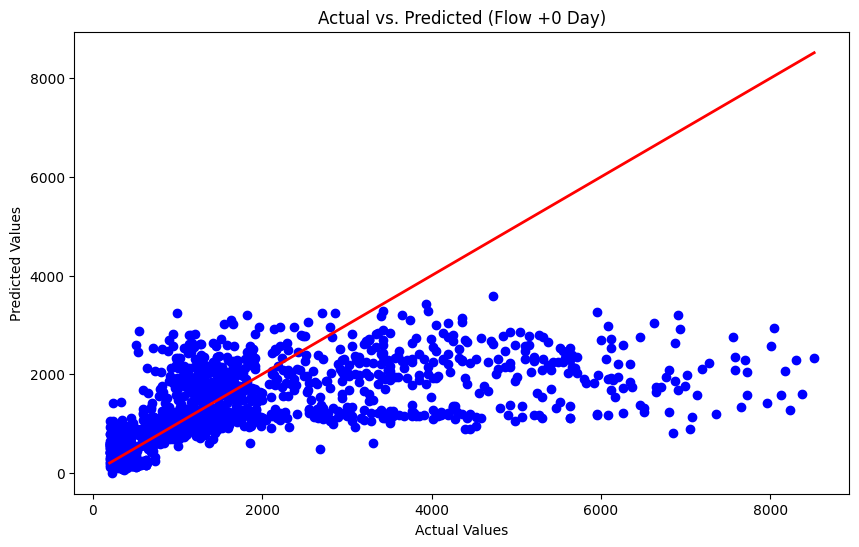

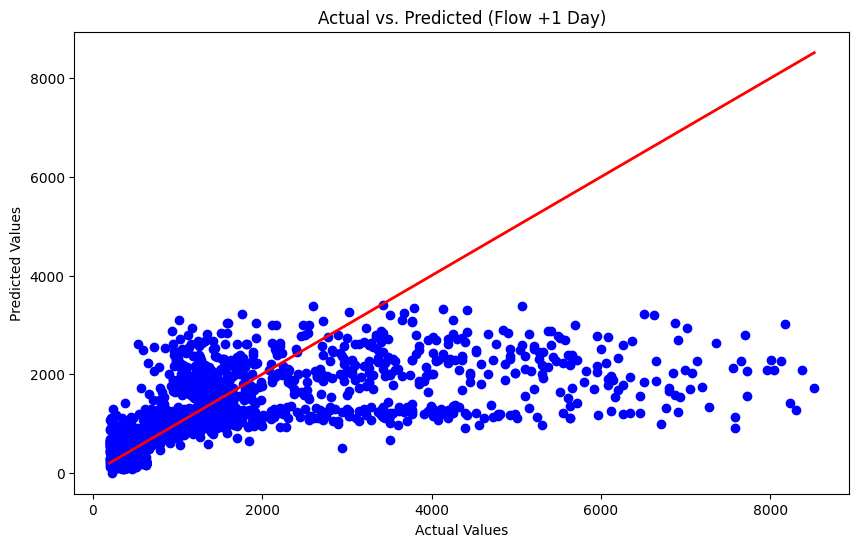

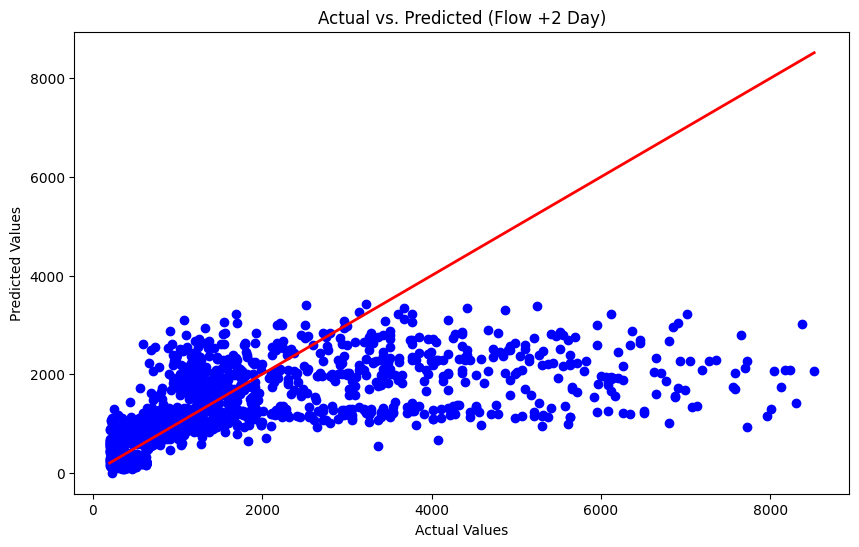

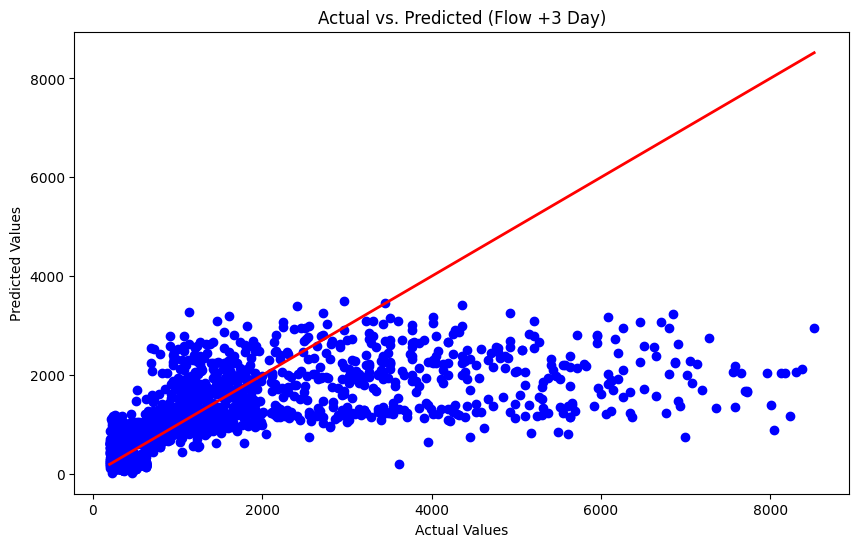

In [435]:
# Scatter plots for each output (Flow+1, Flow+2, Flow+3)
for i in range(Y_pred2_subset.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.scatter(Y2_subset[:, i], Y_pred2_subset[:, i], color='blue')
    plt.plot([min(Y2_subset[:, i]), max(Y2_subset[:, i])], [min(Y2_subset[:, i]), max(Y2_subset[:, i])], color='red', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted (Flow +{i} Day)')
    plt.show()
